#### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
#分类模型评价
from sklearn.metrics import classification_report
#混淆矩阵
from sklearn.metrics import confusion_matrix
#roc,P-R
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False
plt.rcParams.update({'font.size':13 }) #全局字体大小
plt.rcParams["font.family"]=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#### load dataset

In [2]:
train = pd.read_csv('.//data/train.csv')
greeks = pd.read_csv('.//data/greeks.csv')
test = pd.read_csv('.//data/test.csv')
sample_submission = pd.read_csv('.//data/sample_submission.csv')

In [3]:
# train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
# test  = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
# greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
# sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

#### show dataset

In [4]:
print('train:',train.shape)
print('test:',test.shape)
print('greeks:',greeks.shape)

train: (617, 58)
test: (5, 57)
greeks: (617, 6)


In [5]:
train.sample(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
330,81015c6c3404,6.161666,18964.47278,210.557493,85.393581,8.138688,17.983770,0.032886,8.866914,6.767964,...,0.173229,54.94862,NaN,31.636102,296.036174,12261.844150,49.586046,39.457052,21.978000,1
125,321f58c2e5d1,0.499941,4402.36962,149.925435,24.107048,8.138688,6.046267,0.025578,10.297468,1.229900,...,3.253336,0.49706,0.338650,15.180864,208.879930,272.340549,48.968360,23.073412,0.103714,0
309,7bcb9a31014b,0.239288,1143.75008,168.031446,70.577533,8.259300,7.051764,0.194271,10.322676,5.032048,...,0.173229,0.49706,0.067730,18.548188,111.816355,36672.254600,19.751068,65.493408,21.978000,0
240,6002d5f39711,0.470030,7549.83009,102.583311,35.296509,13.775988,5.421708,0.025578,13.001026,5.330738,...,10.096394,1.60312,0.480883,14.845992,576.230778,11483.064390,22.779962,110.932932,0.231623,0
298,7800130b9140,0.414481,4909.35720,88.117662,26.048867,9.968844,6.936597,0.025578,21.357478,1.229900,...,0.173229,1.50104,0.656981,21.189956,500.560942,44126.460400,38.036062,70.447080,21.978000,0


In [6]:
greeks.sample(5)

,Id,Alpha,Beta,Gamma,Delta,Epsilon
345,8856a9d8e2b4,A,B,M,B,Unknown
279,6c6db7987cd5,A,C,M,B,2/18/2019
68,19bf6e929506,A,C,M,B,5/29/2019
577,ed4a24c7ec54,A,C,M,B,Unknown
341,860833bfe713,A,C,M,B,1/31/2019


In [7]:
test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,010ebe33f668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02fa521e1838,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,040e15f562a2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,046e85c7cc7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### dataset info:
**train.csv** - The training set.
+ Id Unique identifier for each observation.
+ AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
+ Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
**test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
**greeks.csv** - Supplemental metadata, only available for the training set.
+ Alpha Identifies the type of age-related condition, if present.
1. A No age-related condition. Corresponds to class 0.
2. B, D, G The three age-related conditions. Correspond to class 1.
+ Beta, Gamma, Delta Three experimental characteristics.
+ Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.
**sample_submission.csv** - A sample submission file in the correct format. See the Evaluation page for more details.<br />


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [9]:
# Description of training data
train.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


In [10]:
# Missing training data
Missing_col = train.isnull().sum()[train.isnull().sum().values!=0]
Missing_col

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

### Handling missing values
Handling ideas:
1. Viewing the Alpha situation of missing values in variable columns
2. Calculate the mean values of the variable columns based on the 'Alpha' obtained in step 1
3. Replace missing values related to this column

In [11]:
# 拼接train和greeks两个数据集
train = pd.merge(train,greeks,on='Id')

In [12]:
train.sample(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon
288,72ee3bca17f6,0.499941,3364.77889,85.200147,32.506112,8.254056,1.869249,0.025578,3.396778,1.229900,...,2119.561668,33.883426,19.470040,0.002386,1,B,B,H,B,5/17/2019
106,2bd50291b64d,0.158101,5543.36090,85.200147,12.409679,10.241532,3.694203,0.025578,11.885572,6.444676,...,2001.336822,27.286093,151.171872,0.303600,0,A,B,M,A,5/2/2020
479,c08f5a77f267,0.431573,2926.50237,85.200147,31.276603,8.138688,3.455010,0.025578,13.057744,4.926628,...,10522.503370,24.636741,118.579488,0.062274,1,B,C,G,D,12/4/2018
326,809087be105e,0.931514,2919.81954,85.200147,35.757962,8.269788,4.571244,0.157731,11.885572,5.446700,...,8899.349148,15.910996,20.789476,21.978000,0,A,C,M,B,Unknown
550,e0bf5a4a77d2,0.282018,2283.32082,85.200147,35.782738,8.972484,7.503573,0.025578,13.328730,1.229900,...,18988.798090,34.102965,96.015332,21.978000,0,A,C,M,B,Unknown


#### 'BQ'

In [13]:
# 查看变量列'BQ'缺失值的 Alpha 情况
train[['BQ','Alpha']][train.BQ.isnull()]['Alpha'].unique()

array(['A'], dtype=object)


分析：缺失值的'Alpha'都为'A';表示:没有与年龄相关的疾病。对应目标变量：类别 0 


In [14]:
# 采用'Alpha'=='A'的'BQ'均值替换此列缺失值
mean = train[train.Alpha=='A']['BQ'].mean()
train.BQ.fillna(mean,inplace=True)

#### 'CB'

In [15]:
# 查看变量列'CB'缺失值的 Alpha 情况
train[['CB','Alpha']][train.CB.isnull()]['Alpha'].unique()

array(['A'], dtype=object)


分析：缺失值的'Alpha'都为'A';表示:没有与年龄相关的疾病。对应目标变量：类别 0 


In [16]:
# 采用'Alpha'=='A'的'CB'均值替换此列缺失值
mean = train[train.Alpha=='A']['CB'].mean()
train.CB.fillna(mean,inplace=True)

#### 'CC'

In [17]:
# 查看变量列'CC'缺失值的 Alpha 情况
train[['CC','Alpha']][train.CC.isnull()]['Alpha'].unique()

array(['A', 'D'], dtype=object)


分析：缺失值的'Alpha'为'A'和'D';表示:既有没有与年龄相关的疾病；也有与年龄相关的疾病。对应目标变量：类别 0 和类别 1 


In [18]:
# 采用'Alpha'=='A'/'D'的'CC'均值替换此列缺失值
mean1 = train[train.Alpha=='A']['CC'].mean()
mean2 = train[train.Alpha=='D']['CC'].mean()

for i in train[(train.Alpha=='A') & (train.CC.isnull())].index:
    temp = train[train.index==i].copy()
    temp.CC=mean1
    train[train.index==i] = temp
for i in train[(train.Alpha=='D') & (train.CC.isnull())].index:
    temp = train[train.index==i].copy()
    temp.CC=mean2
    train[train.index==i] = temp

#### 'DU'

In [19]:
# 查看变量列'DU'缺失值的 Alpha 情况
train[['DU','Alpha']][train.DU.isnull()]['Alpha'].unique()

array(['A'], dtype=object)


分析：缺失值的'Alpha'都为'A';表示:没有与年龄相关的疾病。对应目标变量：类别 0 


In [20]:
# 采用'Alpha'=='A'的'DU'均值替换此列缺失值
mean = train[train.Alpha=='A']['DU'].mean()
train.DU.fillna(mean,inplace=True)

#### 'EL'

In [21]:
# 查看变量列'DU'缺失值的 Alpha 情况
train[['EL','Alpha']][train.EL.isnull()]['Alpha'].unique()

array(['A', 'B', 'G', 'D'], dtype=object)


分析：缺失值的'Alpha'为'A'和'D';表示:既有没有与年龄相关的疾病；也有与年龄相关的疾病。对应目标变量：类别 0 和类别 1 


In [22]:
# 采用'Alpha'=='A'/'D'的'CC'均值替换此列缺失值
mean1 = train[train.Alpha=='A']['EL'].mean()
mean2 = train[train.Alpha=='B']['EL'].mean()
mean3 = train[train.Alpha=='D']['EL'].mean()
mean4 = train[train.Alpha=='G']['EL'].mean()

for i in train[(train.Alpha=='A') & (train.EL.isnull())].index:
    temp = train[train.index==i].copy()
    temp.EL = mean1
    train[train.index==i] = temp
for i in train[(train.Alpha=='B') & (train.EL.isnull())].index:
    temp = train[train.index==i].copy()
    temp.EL = mean2
    train[train.index==i] = temp
for i in train[(train.Alpha=='D') & (train.EL.isnull())].index:
    temp = train[train.index==i].copy()
    temp.EL = mean3
    train[train.index==i] = temp
for i in train[(train.Alpha=='G') & (train.EL.isnull())].index:
    temp = train[train.index==i].copy()
    temp.EL = mean4
    train[train.index==i] = temp

#### 'FC'

In [23]:
# 查看变量列'FC'缺失值的 Alpha 情况
train[['FC','Alpha']][train.FC.isnull()]['Alpha'].unique()

array(['D'], dtype=object)


分析：缺失值的'Alpha'为'A'和'D';表示:有与年龄相关的疾病。对应目标变量：类别 1 


In [24]:
# 采用'Alpha'=='D'的'FC'均值替换此列缺失值
mean = train[train.Alpha=='D']['FC'].mean()
train.FC.fillna(mean,inplace=True)

#### 'FL'

In [25]:
# 查看变量列'FC'缺失值的 Alpha 情况
train[['FL','Alpha']][train.FL.isnull()]['Alpha'].unique()

array(['A'], dtype=object)


分析：缺失值的'Alpha'都为'A';表示:没有与年龄相关的疾病。对应目标变量：类别 0 

In [26]:
# 采用'Alpha'=='A'的'DU'均值替换此列缺失值
mean = train[train.Alpha=='A']['FL'].mean()
train.FL.fillna(mean,inplace=True)

#### 'FS'

In [27]:
# 查看变量列'FC'缺失值的 Alpha 情况
train[['FS','Alpha']][train.FS.isnull()]['Alpha'].unique()

array(['D', 'A'], dtype=object)


分析：缺失值的'Alpha'为'A'和'D';表示:既有没有与年龄相关的疾病；也有与年龄相关的疾病。对应目标变量：类别 0 和类别 1 


In [28]:
# 采用'Alpha'=='A'/'D'的'CC'均值替换此列缺失值
mean1 = train[train.Alpha=='A']['FS'].mean()
mean2 = train[train.Alpha=='D']['FS'].mean()

for i in train[(train.Alpha=='A') & (train.FS.isnull())].index:
    temp = train[train.index==i].copy()
    temp.FS=mean1
    train[train.index==i] = temp
for i in train[(train.Alpha=='D') & (train.FS.isnull())].index:
    temp = train[train.index==i].copy()
    temp.FS=mean2
    train[train.index==i] = temp

#### 'GL'

In [29]:
# 查看变量列'GL'缺失值的 Alpha 情况
train[['GL','Alpha']][train.GL.isnull()]['Alpha'].unique()

array(['A'], dtype=object)


分析：缺失值的'Alpha'都为'A';表示:没有与年龄相关的疾病。对应目标变量：类别 0 

In [30]:
# 采用'Alpha'=='A'的'GL'均值替换此列缺失值
mean = train[train.Alpha=='A']['GL'].mean()
train.GL.fillna(mean,inplace=True)

#### Recheck missing value handling and transform training set(再次检查与转换train)

In [31]:
# 再次检查缺失值处理
train.isnull().sum()[train.isnull().sum().values!=0]

Series([], dtype: int64)

In [32]:
# 去除缺失值后，移除greeks数据集相关列
train = train.iloc[:,0:58]
train.sample(5)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
305,7a5c4b008308,0.414481,2028.57468,100.127373,9.798908,8.138688,8.500210,0.060595,7.719950,2.712808,...,8.456270,0.49706,0.067730,35.775492,139.349725,2605.661784,34.143896,11.847918,0.111028,0
477,bf12446bf394,0.188012,2663.06601,85.200147,11.957517,8.138688,5.023053,0.030755,3.724482,2.164624,...,0.173229,1.45493,0.067730,15.552944,1080.230354,12484.412960,30.608946,66.635376,21.978000,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
465,b874e25c20aa,0.155965,2554.69236,85.200147,10.085380,8.138688,3.410715,0.025578,10.681890,1.229900,...,0.173229,0.49706,0.189644,13.125122,72.611063,25422.746510,41.020304,33.358840,21.978000,0
49,1360fac6a227,0.478576,5192.25520,194.576478,13.230384,8.138688,7.290957,0.025578,9.705080,8.588216,...,10.690335,1.85861,0.067730,12.418170,72.611063,434.357883,34.411808,36.769312,0.050038,1


### EDA

In [33]:
numerical = train.dtypes[train.dtypes=='float64'].index.to_list()


In [34]:
numerical = train.dtypes[train.dtypes=='float64'].index.to_list()
df_numerical = train.loc[:,numerical]
df_numerical

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,9.879296,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,10.910227,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,12.029366,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,8.026928,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622


#### target(目标变量'Class')


distribution of 'Class':


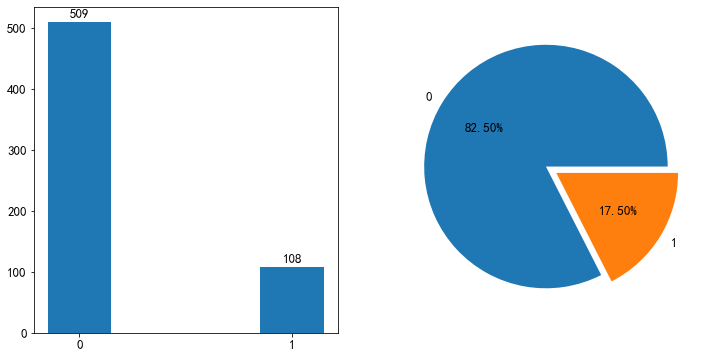

In [35]:
print("distribution of 'Class':")
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
rects = ax1.bar(x=train['Class'].value_counts().index,
       height=train['Class'].value_counts().values,
       width=0.3)
ax1.set_xticks(ticks=[0,1],labels=['0','1'])
ax1.bar_label(rects,padding=3,size=13)

ax2 = plt.subplot(1,2,2)
ax2.pie(train['Class'].value_counts().values,
        labels=train['Class'].value_counts().index,
        autopct='%.2f%%',explode=[0.05,0.05])

plt.show()


分析：训练集当中目标变量的分布情况并不均衡，因此在后续应当考虑变量平衡！

#### distribution(变量分布情况)

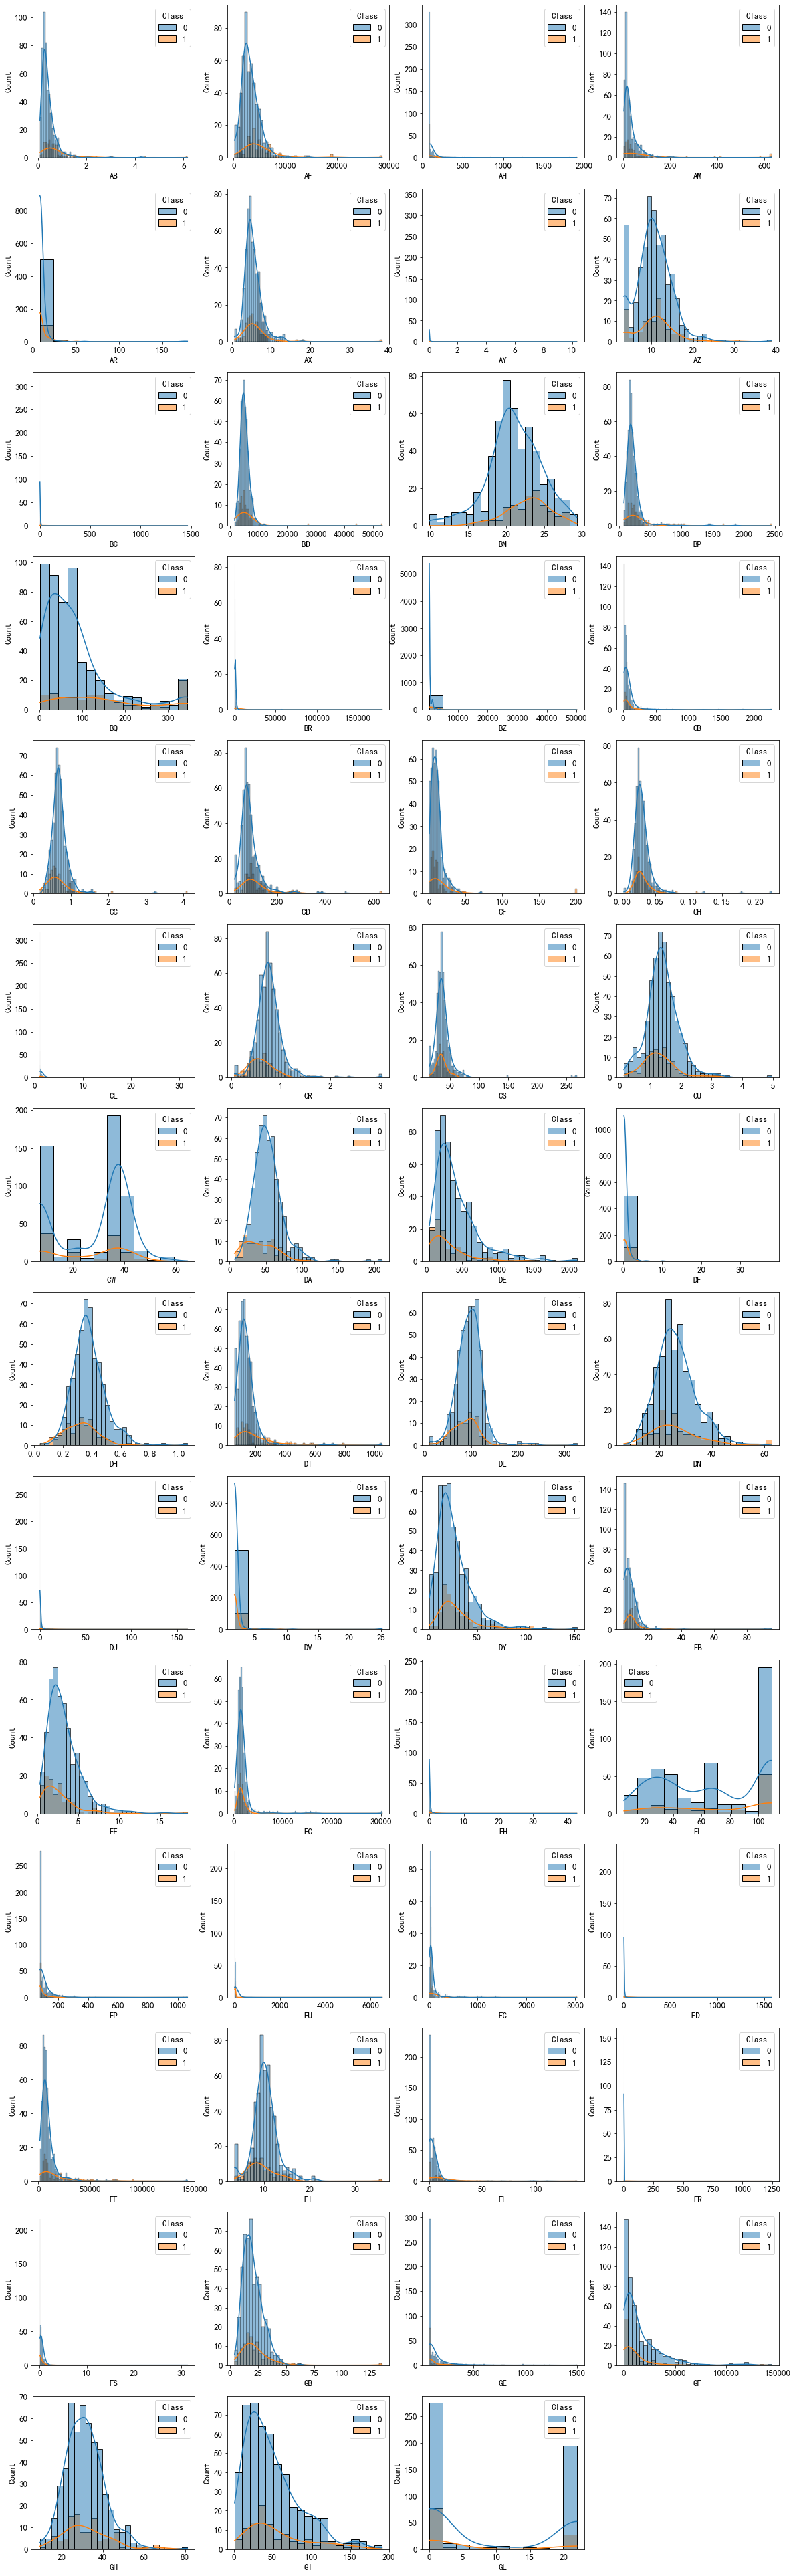

In [38]:
#数值型变量
plt.figure(figsize=(20,70))
i=1
for temp in numerical:
    plt.subplot(14,4,i)
    sns.histplot(data=train,x=temp,hue='Class',kde=True)
    i+=1      
plt.show()

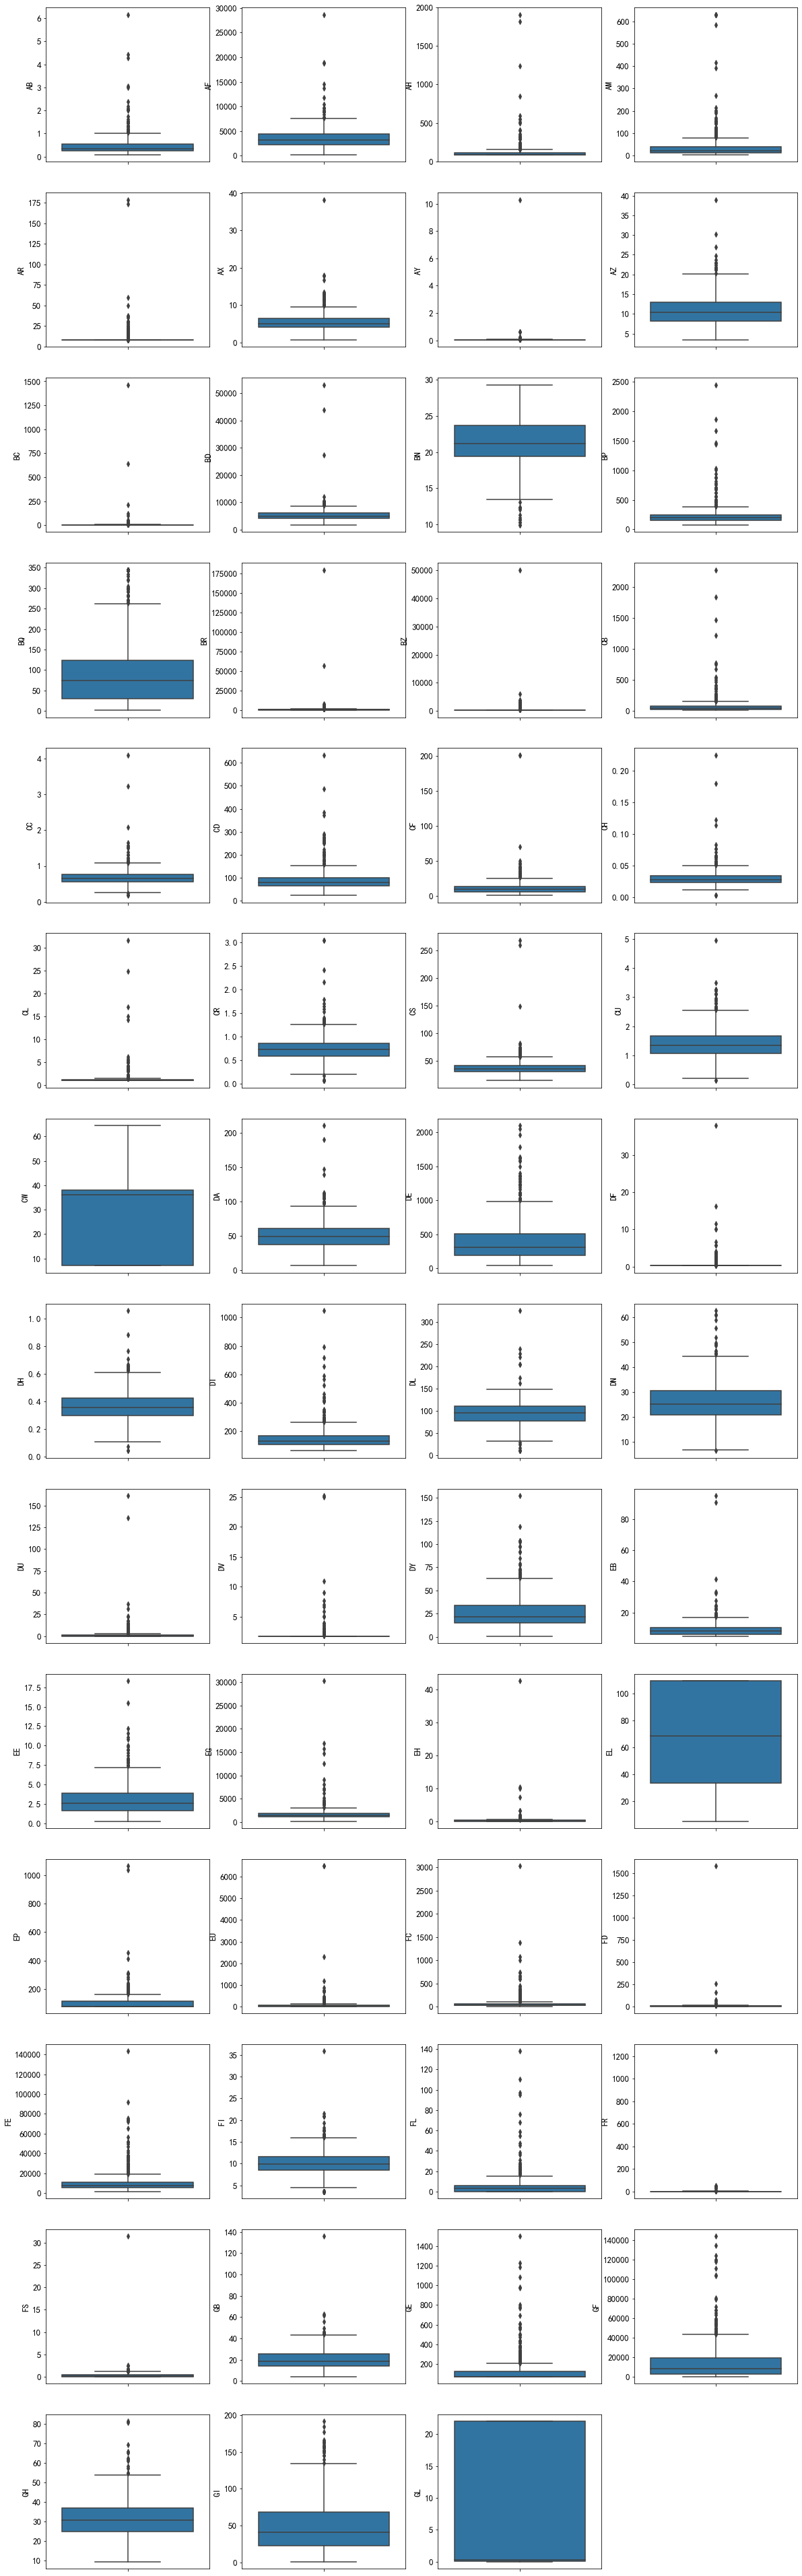

In [39]:
#数值型变量
plt.figure(figsize=(20,70))
i=1
for temp in numerical:
    plt.subplot(14,4,i)
    sns.boxplot(data=train,y=temp,hue='Class')
    i+=1      
plt.show()

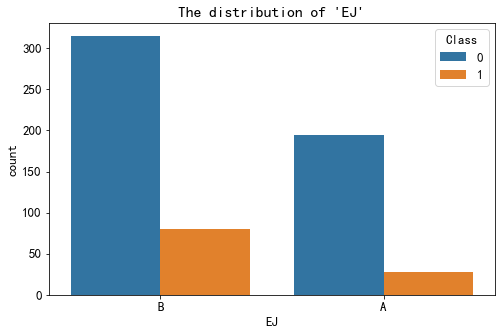

In [40]:
# 类别型变量分布情况
plt.figure(figsize=(8,5))
sns.countplot(data=train,x='EJ',hue='Class')
plt.title("The distribution of 'EJ'")
plt.show()

In [41]:
# 备份数据集
train_ = train.copy()
test_ = test.copy()

### features engineering(特征工程)

#### 标准化之后效果不太好 

In [105]:
# from sklearn.preprocessing import MinMaxScaler

In [106]:
# # 对训练集和测试集采取归一化
# minmaxScaler = MinMaxScaler()

# train_[numerical] = minmaxScaler.fit_transform( train_[numerical] )
# test_[numerical] = minmaxScaler.fit_transform( test_[numerical] )

#### 独热编码转换

In [42]:
# use onehot encoder on 'EJ' of train_(对 train_ 的 'EJ' 进行独热编码转换)
train_ = pd.get_dummies(train_,columns=['EJ'],prefix_sep='_')
train_.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FS,GB,GE,GF,GH,GI,GL,Class,EJ_A,EJ_B
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0,1
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0,1
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,1


In [43]:
# use onehot encoder on 'EJ' of test_(对 test_ 的 'EJ' 进行独热编码转换)
test_ = pd.get_dummies(test_,columns=['EJ'],prefix_sep='_')
test_.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A
0,00eed32682bb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,010ebe33f668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,02fa521e1838,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,040e15f562a2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,046e85c7cc7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
# # 对 train_和 test_ 的 'EJ' 进行独热编码转换
# train_ = pd.get_dummies(train_,columns=['EJ'],prefix_sep='_')
# test_ = pd.get_dummies(test_,columns=['EJ'],prefix_sep='_')

#### 变量相关性筛选（效果一般）

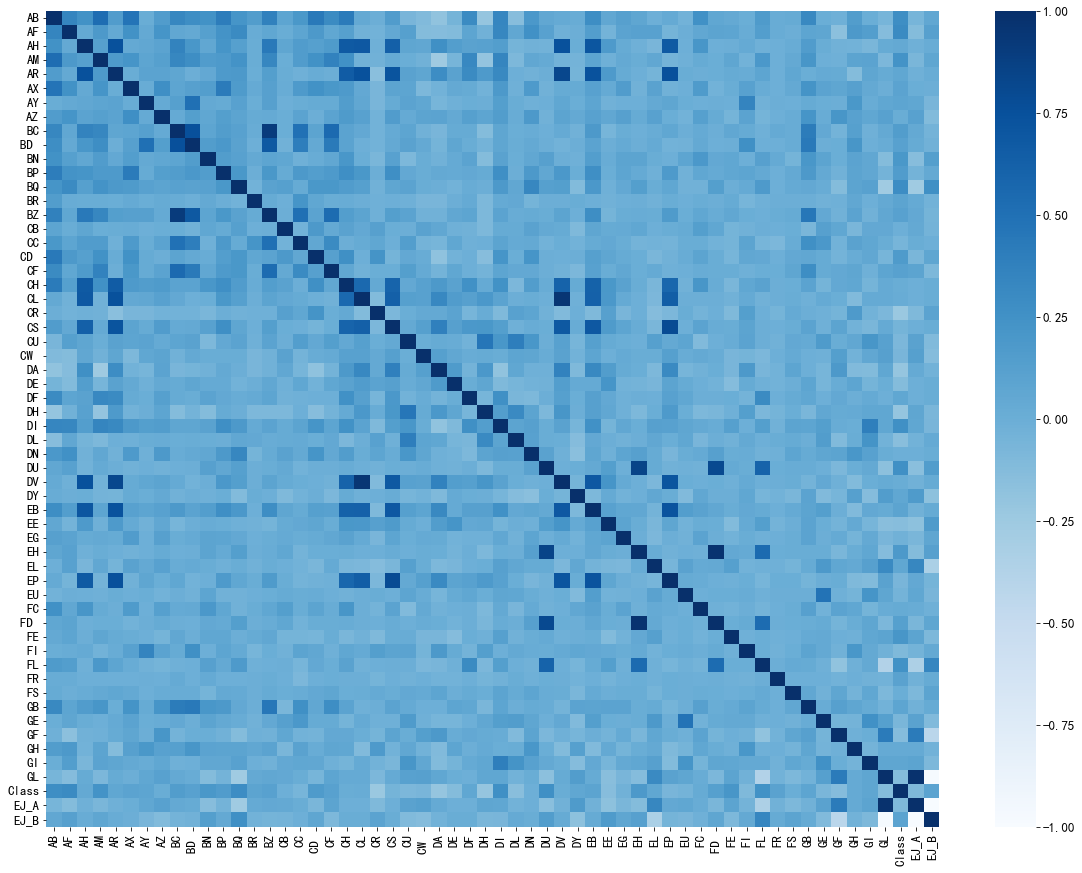

In [44]:
train_corr_data = train_.corr(method='pearson')#numeric_only=True
plt.figure(figsize=(20,15))
sns.heatmap(train_corr_data,cmap=plt.cm.Blues)
plt.show()

In [45]:
print("Top 30 positive correlations with the target")
print(train_corr_data['Class'].sort_values(ascending=False).head(25))

Top 30 positive correlations with the target
Class    1.000000
AF       0.302638
BQ       0.284264
AB       0.280612
DU       0.261042
DI       0.260760
FL       0.244225
AM       0.239170
FE       0.216359
BN       0.198283
EH       0.179855
CD       0.171304
BP       0.157286
BC       0.155882
FD       0.131100
BZ       0.112423
BD       0.112184
CF       0.109748
FR       0.104099
AX       0.097616
EJ_B     0.096500
BR       0.088554
EB       0.088005
GB       0.083343
AY       0.082420
Name: Class, dtype: float64


In [46]:
corr_lt = train_corr_data['Class'].sort_values(ascending=False).head(25).index.to_list()
corr_lt = corr_lt[1:]

In [47]:
#corr_lt

In [48]:
#display("train:",train_.describe().T)
#display("test:",test_.describe().T)

In [49]:
train_.dtypes[train_.dtypes=='object'].index.to_list()

['Id']

In [50]:
#X_train, X_test,Y_train, Y_test = train_test_split(X,Y,train_size=0.70, random_state=10)

In [51]:
# # 切分训练数据进行变量筛选
# from sklearn.model_selection import train_test_split
# X = train_.drop(columns = ['Id', 'Class'], axis = 1)
# Y = train_['Class']

#### Lasso回归筛选（效果一般）

In [52]:
# from sklearn.linear_model import Lasso
# np.seterr(divide='ignore',invalid='ignore')
# plt.figure(figsize=(18,5))
# #alphas = list(np.linspace(0.001,1,20))
# alphas = list(np.logspace(-5,1,20))
# alphas.extend([2,3])
# coef = np.zeros((len(alphas),X.shape[1]))
# err=[]
# for i,alpha in enumerate(alphas):
#     modelLasso = Lasso(alpha = alpha,max_iter=10000)
#     modelLasso.fit(X,Y)
#     if i == 0:
#         coef[i] = modelLasso.coef_
#     else:
#         coef[i] = (modelLasso.coef_/coef[0])
#     err.append(1-modelLasso.score(X,Y))
# print(f'Regression coefficients of the first five features（alpha=0）：{coef[0,][0:5]}')
# #Lasso回归中的收缩系数alpha和回归系数
# ax1 = plt.subplot(1,2,1)
# for i in np.arange(0,X.shape[1]):
#     ax1.plot(coef[1:-1,i])
# ax1.set_title('alpha and regression coefficient')
# ax1.set_xlabel('alpha')
# ax1.set_xticks(np.arange(len(alphas)))
# ax1.set_ylabel('Beta(alpha)/Beta(alpha=0)')

# #Lasso回归中收缩系数alpha和训练误差
# ax2 = plt.subplot(1,2,2)
# ax2.plot(err)
# ax2.set_title('alpha and training errors')
# ax2.set_xlabel('alpha')
# ax2.set_xticks(np.arange(len(alphas)))
# ax2.set_ylabel('Misjudgment rate')
# plt.show()

In [53]:
# from sklearn.linear_model import Lasso,LassoCV
# from sklearn import model_selection
# from sklearn.pipeline import make_pipeline

# #构造不同的lambda值
# lambdas = np.logspace(-5,1,20)
# #设置交叉验证的参数
# lasso_cv = LassoCV(alphas=lambdas,cv=10,max_iter=10000,random_state=10)
# lasso_cv.fit(X,Y)
# # 获取最佳的Lasso回归alpha
# print('Lasso回归最佳的alpha:',lasso_cv.alpha_)

In [54]:
# # 提高最佳的alpha进行Lasso回归建模
# Lasso_model = Lasso(alpha=lasso_cv.alpha_,max_iter=10000,random_state=10)
# Lasso_model.fit(X,Y)
# # 获取权重变量
# display('获取权重变量：',Lasso_model.coef_)

In [55]:
# Lasso_model.feature_names_in_
# feature_importance = pd.DataFrame({'feature':Lasso_model.feature_names_in_.tolist(),
#                                   'coef':Lasso_model.coef_.tolist()})


In [56]:
# print('筛选前的情况：',train_.drop('Class',axis=1).shape)
# print('筛选后的情况：',train_.loc[:,Lasso_X].shape)

In [57]:
# # Lasso回归筛选后
# train_.loc[:,Lasso_X].shape

In [58]:
# # Lasso筛选的变量
# Lasso_X = feature_importance[feature_importance['coef']>0].feature.tolist()
# Lasso_X

In [59]:
# train_corr_data = train_.loc[:,Lasso_X].corr(method='pearson')#numeric_only=True
# plt.figure(figsize=(10,6))
# sns.heatmap(train_corr_data,cmap=plt.cm.Blues)
# plt.show()

In [60]:
# use onehot encoder on 'EJ' of test(对 test 的 'EJ' 进行独热编码转换)
# test_ = pd.get_dummies(test,columns=['EJ'],prefix_sep='_')
# test_.head()

In [61]:
# test_['EJ_B']=0
# test_

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,00eed32682bb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,010ebe33f668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,02fa521e1838,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,040e15f562a2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,046e85c7cc7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### View the distribution of important features after normalization(查看重要特征的分布情况)

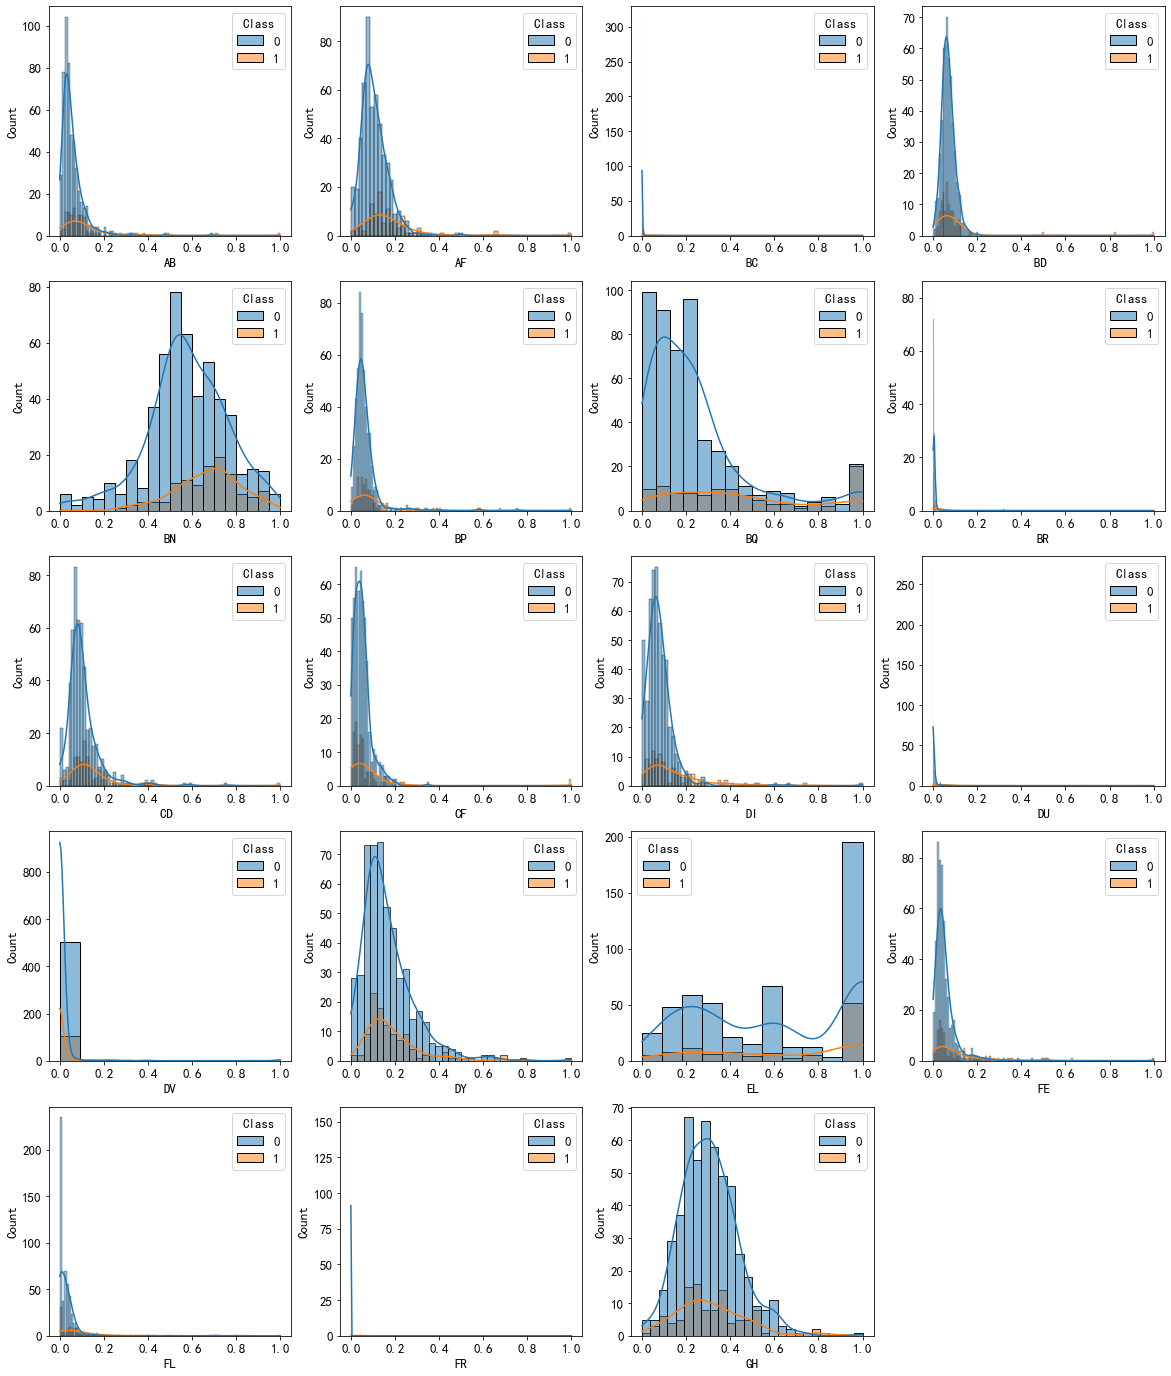

In [324]:
# # numerical variable(进行特征工程之后的变量分布)
# plt.figure(figsize=(20,70))
# i=1
# for temp in Lasso_X:
#     plt.subplot(14,4,i)
#     sns.histplot(data=train_,x=temp,hue='Class',kde=True)
#     i+=1      
# plt.show()

In [54]:
#train_.dtypes

#### Partition Dataset(划分数据集)二选一

In [128]:
# # 按照Lasso回归筛选的结果对train_进行划分训练集和测试集
# X = train_.loc[:,Lasso_X]
# Y = train_['Class']

In [129]:
# # train_ divide training and testing sets(对train_划分训练集和测试集)
# X = train_.loc[:,corr_lt]
# Y = train_['Class']

In [62]:
X_train_ = train_.drop(['Class','Id'],axis=1)
Y = train_['Class']
X_train_

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,0,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,1,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,...,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,1,0
613,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,5654.07556,...,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0,1
614,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,5888.87769,...,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,1,0
615,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,4517.86560,...,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0,1


In [63]:
test_

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,00eed32682bb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,010ebe33f668,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,02fa521e1838,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,040e15f562a2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,046e85c7cc7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Modeling(建模)

#### model selection(模型选择)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train, Y_test = train_test_split(X_train_,Y,train_size=0.70, random_state=10)

In [65]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train,Y_train)

print(f'Accuracy on train set: {RF.score(X_train, Y_train)*100}%')
print(f'Accuracy on test set: {RF.score(X_test, Y_test)*100}%')  
# The evaluation of RandomForest
print(f"model evaluation report:\n{classification_report(Y_test,RF.predict(X_test))}")

Accuracy on train set: 100.0%
Accuracy on test set: 93.01075268817203%
model evaluation report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       157
           1       0.79      0.76      0.77        29

    accuracy                           0.93       186
   macro avg       0.87      0.86      0.87       186
weighted avg       0.93      0.93      0.93       186



In [66]:
# xgboost
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train,Y_train)
print(f'Accuracy on train set: {XGB.score(X_train, Y_train)*100}%')
print(f'Accuracy on test set: {XGB.score(X_test, Y_test)*100}%')  
# The evaluation of XGBClassifier
print(f"model evaluation report:\n{classification_report(Y_test,XGB.predict(X_test))}")

Accuracy on train set: 100.0%
Accuracy on test set: 93.01075268817203%
model evaluation report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       157
           1       0.77      0.79      0.78        29

    accuracy                           0.93       186
   macro avg       0.86      0.87      0.87       186
weighted avg       0.93      0.93      0.93       186



Result: From the comprehensive results of the above two models, the xgboost model performs better!<br />
结果：从上面两种模型的综合结果来看，xgboost模型效果更胜一筹！

In [67]:
# 初始建模
XGB = XGBClassifier()
XGB.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

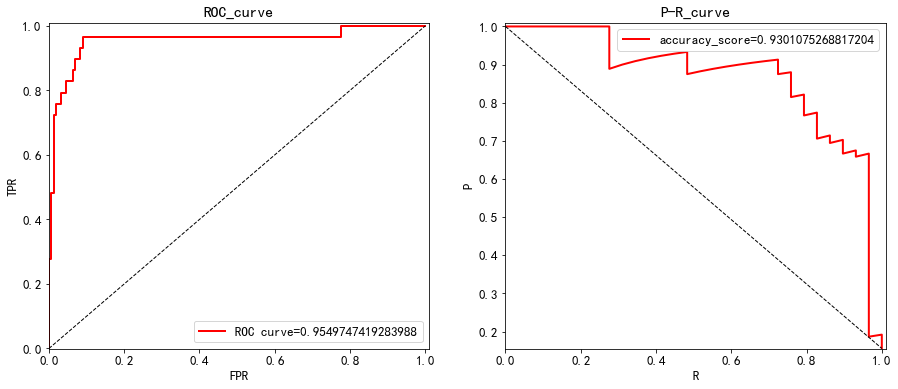

ROC最佳阈值: 0.09533707
P-R最佳阈值: 0.00033252058
AUC： 0.9549747419283988
The total accuracy is： 0.9301075268817204


In [68]:
#ROC曲线和P-R曲线
#FTR:假阳性率，TPR：真阳性率
FPR,TPR,thresholds = roc_curve(Y_test,XGB.predict_proba(X_test)[:,1],pos_label=1)
# ROC 确定阈值
temp1 = TPR-FPR
idx1 = np.argmax(temp1)
best_threshold_roc = thresholds[idx1]

roc_auc = auc(FPR,TPR)  #auc值
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(FPR,TPR,color = 'r',linewidth=2,label=f'ROC curve={roc_auc}')
plt.plot([0,1],[0,1],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([-0.001,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
PRE,REC,thresholds = precision_recall_curve(Y_test,XGB.predict_proba(X_test)[:,1],pos_label=1)
# P_R 确定阈值
temp2 = TPR-FPR
idx2 = np.argmax(temp2)
best_threshold_pr = thresholds[idx2]

plt.plot(REC,PRE,color = 'r',linewidth=2,label=f'accuracy_score={accuracy_score(Y_test,XGB.predict(X_test))}')
plt.plot([0,1],[1,PRE.min()],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([PRE.min()-0.001,1.01])
plt.xlabel('R')
plt.ylabel('P')
plt.title('P-R_curve')
plt.legend(loc = 'best')
plt.show()

print('ROC最佳阈值:',best_threshold_roc)
print('P-R最佳阈值:',best_threshold_pr)
print("AUC：",roc_auc)
print("The total accuracy is：",accuracy_score(Y_test,XGB.predict(X_test)))

In [70]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score
# 初始建模
XGB = XGBClassifier()
XGB.fit(X_train,Y_train)

Y_pred = XGB.predict(X_test.values)
recall = recall_score(Y_test, Y_pred)
print("Recall_score: %.2f%%" % (recall * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(XGB.feature_importances_)
thresh_lt=[]
n_lt = []
recall_lt=[]
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(XGB, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train.values)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test.values)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    recall = recall_score(Y_test, predictions)
    thresh_lt.append(thresh)
    n_lt.append(select_X_train.shape[1])
    recall_lt.append(recall*100.0)
df_temp = pd.DataFrame({'threshold':thresholds,'n':n_lt,'recall(%)':recall_lt})
df_temp

Recall_score: 79.31%


,threshold,n,recall(%)
0,0.000000,57,79.310345
1,0.000000,57,79.310345
2,0.000000,57,79.310345
3,0.000000,57,79.310345
4,0.000559,53,79.310345
5,0.000961,52,79.310345
6,0.002898,51,79.310345
7,0.002978,50,79.310345
8,0.003224,49,82.758621
9,0.003710,48,79.310345


In [71]:
df_temp.sort_values(by=['recall(%)'],ascending=False).iloc[[0],:]

,threshold,n,recall(%)
20,0.009618,37,86.206897


In [72]:
df_temp.threshold.median()

0.01182172168046236

#### SelectFromModel

#### median

In [79]:
from sklearn.feature_selection import SelectFromModel
# XGBoostClassifer作为基模型的特征选择
selector_XGBC = SelectFromModel(XGBClassifier(),threshold='median').fit(X_train,Y_train)

In [80]:
print('SelectFromModel筛选前的特征变量维度：',X_train.shape)
print('SelectFromModel筛选后的特征变量维度：',selector_XGBC.transform(X_train).shape)

SelectFromModel筛选前的特征变量维度： (431, 57)
SelectFromModel筛选后的特征变量维度： (431, 29)


In [81]:
selector_X = X_train.columns[selector_XGBC.get_support()].to_list()
print('筛选后的特征变量个数:',len(selector_X))

筛选后的特征变量个数: 29


#### RandomForestClassifier

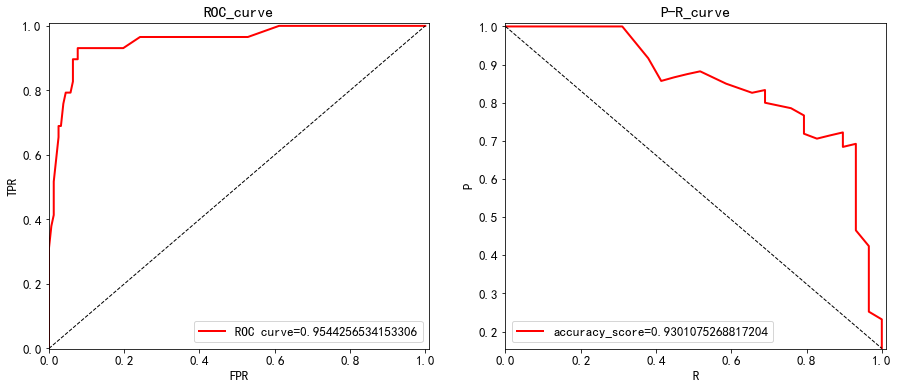

ROC最佳阈值: 0.34
P-R最佳阈值: 0.16
AUC： 0.9544256534153306
The total accuracy is： 0.9301075268817204


In [82]:
#ROC曲线和P-R曲线
#FTR:假阳性率，TPR：真阳性率
FPR,TPR,thresholds = roc_curve(Y_test,RF.predict_proba(X_test)[:,1],pos_label=1)
# ROC 确定阈值
temp1 = TPR-FPR
idx1 = np.argmax(temp1)
best_threshold_roc = thresholds[idx1]

roc_auc = auc(FPR,TPR)  #auc值
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(FPR,TPR,color = 'r',linewidth=2,label=f'ROC curve={roc_auc}')
plt.plot([0,1],[0,1],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([-0.001,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
PRE,REC,thresholds = precision_recall_curve(Y_test,RF.predict_proba(X_test)[:,1],pos_label=1)
# P_R 确定阈值
temp2 = TPR-FPR
idx2 = np.argmax(temp2)
best_threshold_pr = thresholds[idx2]

plt.plot(REC,PRE,color = 'r',linewidth=2,label=f'accuracy_score={accuracy_score(Y_test,RF.predict(X_test))}')
plt.plot([0,1],[1,PRE.min()],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([PRE.min()-0.001,1.01])
plt.xlabel('R')
plt.ylabel('P')
plt.title('P-R_curve')
plt.legend(loc = 'best')
plt.show()

print('ROC最佳阈值:',best_threshold_roc)
print('P-R最佳阈值:',best_threshold_pr)
print("AUC：",roc_auc)
print("The total accuracy is：",accuracy_score(Y_test,RF.predict(X_test)))

In [83]:
from sklearn.feature_selection import SelectFromModel
# RandomForestClassifier作为基模型的特征选择
selector_RF = SelectFromModel(RandomForestClassifier()).fit(X_train,Y_train)

In [84]:
print('SelectFromModel筛选前的特征变量维度：',X_train.shape)
print('SelectFromModel筛选后的特征变量维度：',selector_RF.transform(X_train).shape)

SelectFromModel筛选前的特征变量维度： (431, 57)
SelectFromModel筛选后的特征变量维度： (431, 17)


In [85]:
selector_RF.get_support()

array([ True,  True, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False,  True,  True,
       False,  True,  True, False, False, False, False, False, False,
        True, False, False])

In [86]:
selector_X_RF = X_train.columns[selector_RF.get_support()].to_list()
print('筛选后的特征变量个数:',len(selector_X_RF))

筛选后的特征变量个数: 17


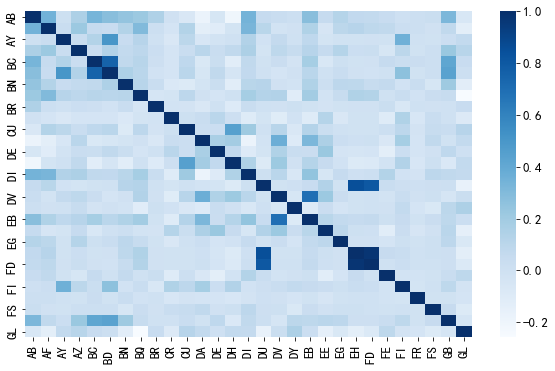

In [87]:
train_corr_data = train_.loc[:,selector_X].corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(train_corr_data,cmap=plt.cm.Blues)
plt.show()

In [326]:
# from sklearn.feature_selection import RFE
# for n in range(2,59):
#     model = XGBClassifier()
#     rfe = RFE(model,n_features_to_select=n)
#     RFE_X_train = rfe.fit_transform(X_train,Y_train)
#     RFE_X_test = rfe.transform(X_test)
#     rfe = rfe.fit(RFE_X_train,Y_train)

#     print(f"when n={n} Accuracy is { rfe.score(RFE_X_test,Y_test)}")

In [230]:
# 按照筛选的结果对train_进行划分训练集和测试集
X = train_.loc[:,selector_X]
Y = train_['Class']

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train, Y_test = train_test_split(X,Y,train_size=0.70, random_state=10)

In [90]:
X_train

,AB,AF,AY,AZ,BC,BD,BN,BQ,BR,CR,...,EE,EG,EH,FD,FE,FI,FR,FS,GB,GL
166,0.269199,2045.32350,0.025578,10.971782,1.229900,4136.20727,20.4798,85.032271,333.538836,0.470288,...,1.467284,2135.901663,0.054756,0.902424,3455.444025,7.908398,0.49706,0.067730,15.673870,0.053460
326,0.931514,2919.81954,0.157731,11.885572,5.446700,4777.46869,22.2453,10.990495,799.472134,0.690825,...,0.354728,2796.443500,0.003042,0.296850,6855.349416,10.662142,0.49706,0.101595,12.055392,21.978000
249,0.927241,8941.06389,0.097135,10.133616,5.854324,3747.62161,27.5418,344.644105,471.649604,0.421950,...,1.378602,1385.843388,0.006084,0.296850,35125.281440,6.808555,0.78561,0.927901,34.854594,0.001129
499,0.166647,2422.71161,0.088000,8.299734,1.995952,4545.76668,25.0701,10.617980,191.780520,0.776700,...,4.506658,697.101537,0.003042,0.296850,9915.132140,7.977311,1.37779,0.413153,12.557700,21.978000
126,0.717864,2394.81143,0.025578,10.231297,1.229900,4778.25970,18.3612,12.847860,1902.159467,0.723750,...,2.755189,1411.720763,0.091260,1.769226,7410.402629,6.461236,0.77111,1.307189,13.390229,0.193696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0.405935,192.59328,0.025578,6.402832,1.229900,6287.19517,18.7143,85.032271,939.669807,0.718575,...,3.277203,1040.324700,0.006084,2.499477,3683.179374,11.213442,0.87696,1.219140,9.525248,0.019800
320,0.504214,2725.99932,0.025578,6.339812,1.229900,3968.05772,20.8329,25.521185,2834.963659,0.696675,...,3.958442,777.478050,0.121680,2.505414,6264.352174,7.365368,1.06285,0.067730,36.249894,0.625263
527,0.888784,4484.75368,0.099876,9.371074,13.500788,4222.32349,24.0108,16.414105,914.276105,1.582500,...,1.314106,906.292550,0.006084,0.296850,12255.420430,9.228762,0.87928,1.036269,17.245908,0.198000
125,0.499941,4402.36962,0.025578,10.297468,1.229900,3237.76373,20.1267,85.032271,1623.705850,0.537150,...,8.424790,1268.379988,0.066924,1.128030,8145.464198,7.935963,0.49706,0.338650,15.180864,0.103714


#### Model optimal parameters(模型最优参数)

In [334]:
# from sklearn.model_selection import GridSearchCV,StratifiedKFold
# from xgboost import XGBClassifier
# from sklearn.model_selection import KFold,StratifiedKFold
# XGB_model = XGBClassifier()
# #params
# parameters = {'learning_rate':[0.01,0.025,0.1],'subsample':[0.6,0.8],
#             'max_depth':[3,6,9],'n_estimators':[300,800,1500],
#              'min_child_weight':[2,4,6],'max_delta_step':[3,5,7],
#              'eta':[0.1,0.3],'gamma':[0.3, 0.5, 0.9]
#             }
# #5fold
# kfold = KFold(n_splits=5, shuffle=True, random_state=10)
# #GridSearchCV
# grid_search = GridSearchCV(XGB_model, parameters, scoring="recall",n_jobs=-1,cv=kfold)
# grid_result = grid_search.fit(X_train,Y_train)
# #best results
# print(f"Best:{grid_result.best_score_};\nusing:\n{grid_result.best_params_}")

Best:0.7461011503116767;
using:
{'eta': 0.1, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 3, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 800, 'subsample': 0.8}


#### 在网格调优的最优参数下探索模型复杂度与训练误差，测试误差以及交叉验证误差之间的情况

In [207]:
# 对数损失函数
def competition_log_loss(y_true, y_pred):
    # y_true: 真实值 标签 0, 1
    # y_pred: 预测患病（class=1）的概率
    # 使用实现评估方程式 w_0 = w_1 = 1.
    #计算每个类别的观测次数
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # 计算每个类别的预测概率
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # 计算每类的平均对数损失
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # 返回
    return (log_loss_0 + log_loss_1)/2

In [140]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [172]:
trainErr = []  #训练误差
testErr = []   #测试误差
CV_recall_Err = []     #交叉验证召回率误差
CV_f1_Err = []        #交叉验证f1误差
CV_precision_Err = []#交叉验证精确率误差
log_loss_lt = []
for k in np.arange(100,2000,100):  #模型复杂度 K
    # model
    XGBC_model = XGBClassifier(n_estimators=k,max_depth=6,learning_rate=0.01,
                            subsample=0.5,eta=0.1,max_delta_step=3,min_child_weight=2,
                            random_state=10)
    XGBC_model.fit(X_train,Y_train)
    y_pred = XGBC_model.predict(X_test)
    test_prob = XGBC_model.predict_proba(X_test)
    test_prob_df = pd.DataFrame(test_prob, columns=['class_0', 'class_1'])
    log_loss = competition_log_loss(Y_test,test_prob_df.class_1.to_list())
    log_loss_lt.append(log_loss)
    trainErr.append(1-XGBC_model.score(X_train,Y_train))
    testErr.append(1-(XGBC_model.score(X_test,Y_test)))
    recall_Err = 1-cross_val_score(XGBC_model,X,Y,cv=5,scoring='recall')
    f1_Err = 1-cross_val_score(XGBC_model,X,Y,cv=5,scoring='f1')
    precision_Err = 1-cross_val_score(XGBC_model,X,Y,cv=5,scoring='precision')
    CV_recall_Err.append(recall_Err.mean())
    CV_f1_Err.append(f1_Err.mean())
    CV_precision_Err.append(precision_Err.mean())

In [173]:
log_loss_lt

[0.46195215056254635,
 0.39854783126738863,
 0.3639796459866088,
 0.3472178627745604,
 0.33775563137220804,
 0.32686818904358395,
 0.3260908863906716,
 0.3235149575804163,
 0.32394870205505644,
 0.3283670786006373,
 0.3265100110308912,
 0.3269852917495294,
 0.3270613848860807,
 0.3312336943865726,
 0.3356552971557911,
 0.33469969424620866,
 0.33375505411649853,
 0.3350828707033375,
 0.3353593752093091]

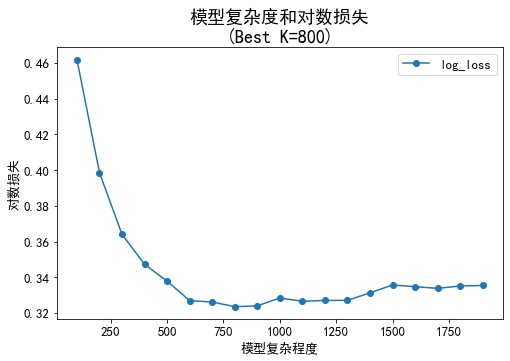

In [174]:
K = np.arange(100,2000,100)
plt.figure(figsize=(8,5))
plt.plot(K,log_loss_lt,label='log_loss',marker='o',linestyle = '-')
bestK = K[log_loss_lt.index(np.min(log_loss_lt))]
plt.xlabel('模型复杂程度')
plt.ylabel('对数损失')
plt.legend()
plt.title(f'模型复杂度和对数损失\n(Best K={bestK})',fontsize=18)
plt.show()

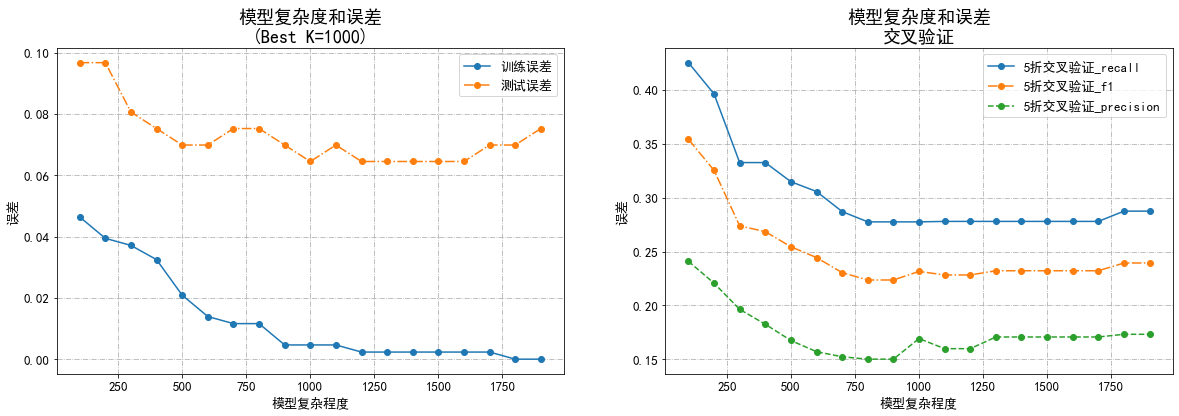

In [175]:
K = np.arange(100,2000,100)
plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,2,1)
ax1.grid(True,linestyle = '-.')
ax1.plot(K,trainErr,label='训练误差',marker='o',linestyle = '-')
ax1.plot(K,testErr,label='测试误差',marker='o',linestyle = '-.')
bestK = K[testErr.index(np.min(testErr))]
ax1.set_xlabel('模型复杂程度')
ax1.set_ylabel('误差')
ax1.legend()
ax1.set_title(f'模型复杂度和误差\n(Best K={bestK})',fontsize=18)
ax2 = plt.subplot(1,2,2)
ax2.grid(True,linestyle = '-.')
ax2.plot(K,CV_recall_Err,label='5折交叉验证_recall',marker='o',linestyle = '-')
ax2.plot(K,CV_f1_Err,label='5折交叉验证_f1',marker='o',linestyle = '-.')
ax2.plot(K,CV_precision_Err,label='5折交叉验证_precision',marker='o',linestyle = '--')
ax2.set_xlabel('模型复杂程度')
ax2.set_ylabel('误差')
ax2.legend()
ax2.set_title(f'模型复杂度和误差\n交叉验证',fontsize=18)
plt.show()

从上图得出，当模型复杂度为1000左右时，模型测试误差已经趋于平稳且变化较小！

#### optimization model(最优模型建立)

In [213]:
from xgboost import XGBClassifier
# model
XGBC_model = XGBClassifier(max_depth=6, learning_rate=0.01,n_estimators=900,
                            subsample=0.5,max_delta_step=3,eta=0.1,
                            min_child_weight=2,random_state=10)

In [214]:
#把train_划分的训练集进行模型训练
XGBC_model.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=3, max_depth=6,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

#### model evaluation(模型评价)

In [215]:
# 模型的评价
print(f"model evaluation report:\n{classification_report(Y_test,XGBC_model.predict(X_test))}")

model evaluation report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       157
           1       0.75      0.83      0.79        29

    accuracy                           0.93       186
   macro avg       0.86      0.89      0.87       186
weighted avg       0.93      0.93      0.93       186



confusion matrix：
[[149   8]
 [  5  24]]



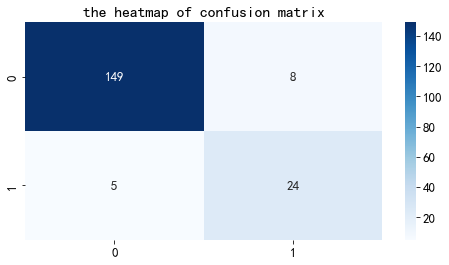

In [216]:
# 混淆矩阵
cnf_matrix = confusion_matrix(Y_test,XGBC_model.predict(X_test))
print(f'confusion matrix：\n{cnf_matrix}\n')
plt.figure(figsize=(8,4))
sns.heatmap(cnf_matrix,annot=True,cmap=plt.cm.Blues,fmt='g')
plt.title('the heatmap of confusion matrix')
plt.show()

In [217]:
XGBC_model.feature_importances_

array([0.03631218, 0.04134233, 0.02734419, 0.01926647, 0.0527767 ,
       0.01615193, 0.02441029, 0.0464306 , 0.01950539, 0.06872214,
       0.0292628 , 0.05088988, 0.02791398, 0.02654028, 0.05317606,
       0.09122641, 0.02262032, 0.03138279, 0.02511518, 0.03188259,
       0.02886932, 0.02703348, 0.02944481, 0.02542715, 0.02739808,
       0.02965283, 0.02609038, 0.01623136, 0.04758002], dtype=float32)

In [218]:
len(XGBC_model.feature_names_in_.tolist())

29

In [219]:
XGBC_model.feature_names_in_.tolist()

['AB',
 'AF',
 'AY',
 'AZ',
 'BC',
 'BD ',
 'BN',
 'BQ',
 'BR',
 'CR',
 'CU',
 'DA',
 'DE',
 'DH',
 'DI',
 'DU',
 'DV',
 'DY',
 'EB',
 'EE',
 'EG',
 'EH',
 'FD ',
 'FE',
 'FI',
 'FR',
 'FS',
 'GB',
 'GL']

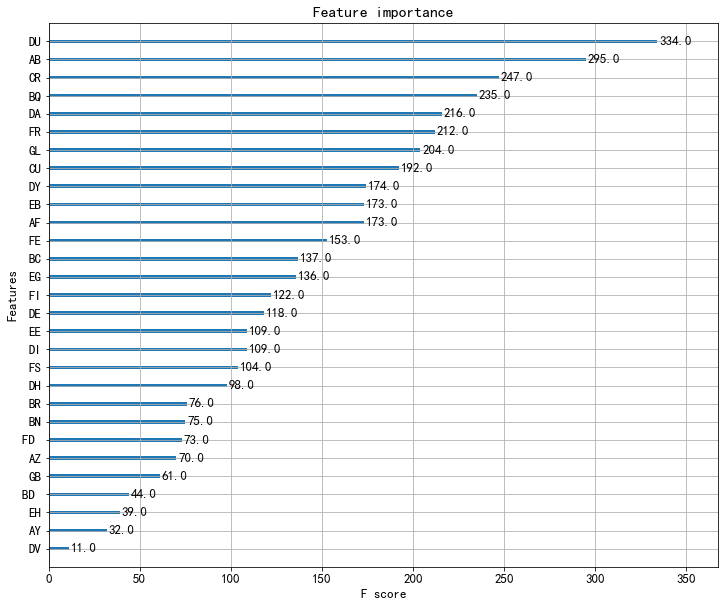

In [220]:
# 显示特征变量重要性
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (12,10)
plot_importance(XGBC_model)
plt.show()

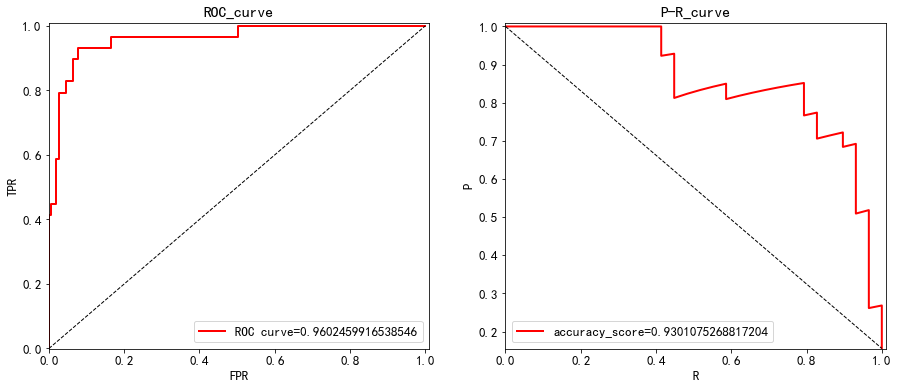

AUC： 0.9602459916538546
The total accuracy is： 0.9301075268817204


In [221]:
#ROC曲线和P-R曲线
#FTR:假阳性率，TPR：真阳性率
FPR,TPR,thresholds = roc_curve(Y_test,XGBC_model.predict_proba(X_test)[:,1],pos_label=1)

roc_auc = auc(FPR,TPR)  #auc值
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(FPR,TPR,color = 'r',linewidth=2,label=f'ROC curve={roc_auc}')
plt.plot([0,1],[0,1],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([-0.001,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
PRE,REC,thresholds = precision_recall_curve(Y_test,XGBC_model.predict_proba(X_test)[:,1],pos_label=1)
plt.plot(REC,PRE,color = 'r',linewidth=2,label=f'accuracy_score={accuracy_score(Y_test,XGBC_model.predict(X_test))}')
plt.plot([0,1],[1,PRE.min()],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([PRE.min()-0.001,1.01])
plt.xlabel('R')
plt.ylabel('P')
plt.title('P-R_curve')
plt.legend(loc = 'best')
plt.show()


print("AUC：",roc_auc)
print("The total accuracy is：",accuracy_score(Y_test,XGBC_model.predict(X_test)))

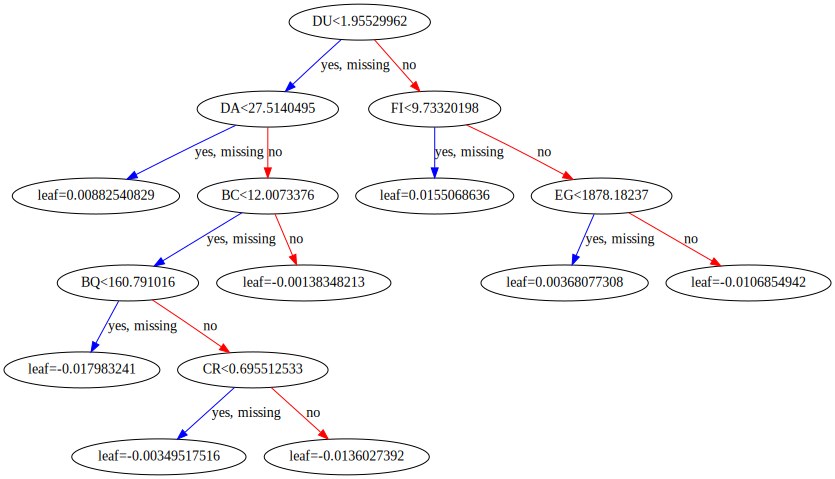

In [222]:
#模型可视化（部分）
import xgboost
digraph1 = xgboost.to_graphviz(XGBC_model,num_trees=10)
digraph1

#### Final establishment of the model(模型最终建立)

### RF数据准备

In [118]:
# 按照筛选的结果对train_进行划分训练集和测试集
RF_X = train_.loc[:,selector_X_RF]
RF_Y = train_['Class']

In [119]:
from sklearn.model_selection import train_test_split
RF_X_train, RF_X_test,RF_Y_train, RF_Y_test = train_test_split(RF_X,RF_Y,train_size=0.70, random_state=10)

### RandomForestClassifier

In [120]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold,StratifiedKFold
RF = RandomForestClassifier()
#params
parameters = {'max_features':[0.5,0.9],'max_depth':[3,6],
              'n_estimators':[100,300,800,1500],
             'min_samples_leaf':[2,4,6],'min_samples_split':[3,5,7]
            }
#5fold
kfold = KFold(n_splits=5, shuffle=True, random_state=10)
#GridSearchCV
grid_search = GridSearchCV(RF, parameters, scoring="roc_auc",n_jobs=-1,cv=kfold)
grid_result = grid_search.fit(RF_X,RF_Y)
#best results
print(f"Best:{grid_result.best_score_};\nusing:\n{grid_result.best_params_}")

Best:0.942293452181737;
using:
{'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 100}


In [121]:
from sklearn.model_selection import cross_val_score
trainErr = []  #训练误差
testErr = []   #测试误差
CV_recall_Err = []     #交叉验证召回率误差
CV_f1_Err = []        #交叉验证f1误差
CV_precision_Err = []#交叉验证精确率误差
for k in np.arange(100,2000,100):  #模型复杂度 K
    # model
    RF = RandomForestClassifier(n_estimators=k,max_depth=6, max_features=0.5,
                            min_samples_leaf=2,min_samples_split=3,random_state=10)
    RF.fit(X_train,Y_train)
    trainErr.append(1-RF.score(X_train,Y_train))
    testErr.append(1-(RF.score(X_test,Y_test)))
    recall_Err = 1-cross_val_score(RF,X,Y,cv=5,scoring='recall')
    f1_Err = 1-cross_val_score(RF,X,Y,cv=5,scoring='f1')
    precision_Err = 1-cross_val_score(RF,X,Y,cv=5,scoring='precision')
    CV_recall_Err.append(recall_Err.mean())
    CV_f1_Err.append(f1_Err.mean())
    CV_precision_Err.append(precision_Err.mean())

In [209]:
trainErr = []  #训练误差
testErr = []   #测试误差
CV_recall_Err = []     #交叉验证召回率误差
CV_f1_Err = []        #交叉验证f1误差
CV_precision_Err = []#交叉验证精确率误差
log_loss_lt = []
for k in np.arange(100,2000,100):  #模型复杂度 K
    # model
    RF = RandomForestClassifier(n_estimators=k,max_depth=6, max_features=0.5,
                            min_samples_leaf=2,min_samples_split=3,random_state=10)
    RF.fit(RF_X_train,RF_Y_train)
    y_pred = RF.predict(RF_X_test)
    test_prob = RF.predict_proba(RF_X_test)
    test_prob_df = pd.DataFrame(test_prob, columns=['class_0', 'class_1'])
    log_loss = competition_log_loss(RF_Y_test,test_prob_df.class_1.to_list())
    log_loss_lt.append(log_loss)
    trainErr.append(1-RF.score(RF_X_train,RF_Y_train))
    testErr.append(1-(RF.score(RF_X_test,RF_Y_test)))
    recall_Err = 1-cross_val_score(RF,RF_X,RF_Y,cv=5,scoring='recall')
    f1_Err = 1-cross_val_score(RF,RF_X,RF_Y,cv=5,scoring='f1')
    precision_Err = 1-cross_val_score(RF,RF_X,RF_Y,cv=5,scoring='precision')
    CV_recall_Err.append(recall_Err.mean())
    CV_f1_Err.append(f1_Err.mean())
    CV_precision_Err.append(precision_Err.mean())

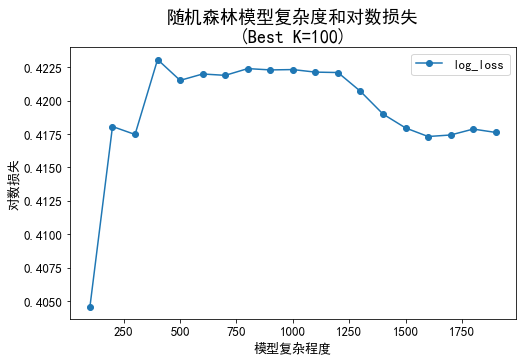

In [212]:
K = np.arange(100,2000,100)
plt.figure(figsize=(8,5))
plt.plot(K,log_loss_lt,label='log_loss',marker='o',linestyle = '-')
bestK = K[log_loss_lt.index(np.min(log_loss_lt))]
plt.xlabel('模型复杂程度')
plt.ylabel('对数损失')
plt.legend()
plt.title(f'随机森林模型复杂度和对数损失\n(Best K={bestK})',fontsize=18)
plt.show()

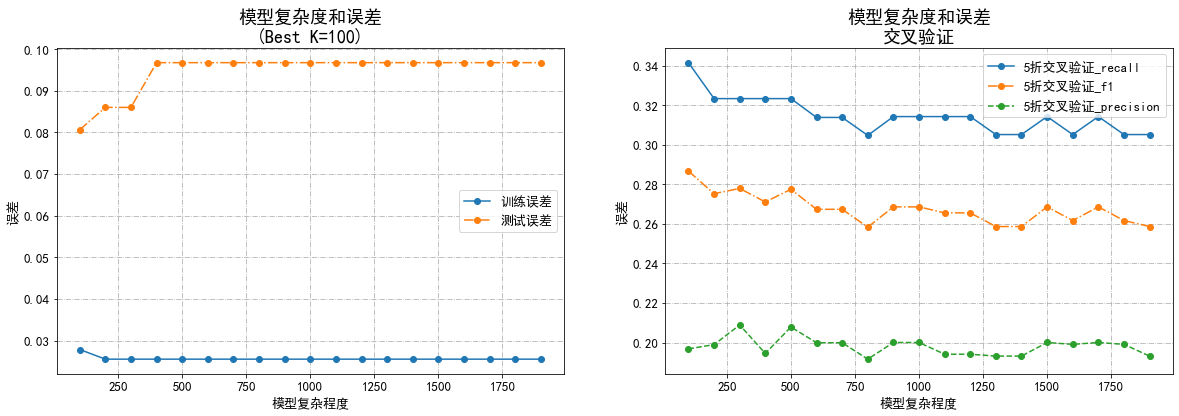

In [211]:
K = np.arange(100,2000,100)
plt.figure(figsize=(20,6))
ax1 = plt.subplot(1,2,1)
ax1.grid(True,linestyle = '-.')
ax1.plot(K,trainErr,label='训练误差',marker='o',linestyle = '-')
ax1.plot(K,testErr,label='测试误差',marker='o',linestyle = '-.')
bestK = K[testErr.index(np.min(testErr))]
ax1.set_xlabel('模型复杂程度')
ax1.set_ylabel('误差')
ax1.legend()
ax1.set_title(f'模型复杂度和误差\n(Best K={bestK})',fontsize=18)

ax2 = plt.subplot(1,2,2)
ax2.grid(True,linestyle = '-.')
ax2.plot(K,CV_recall_Err,label='5折交叉验证_recall',marker='o',linestyle = '-')
ax2.plot(K,CV_f1_Err,label='5折交叉验证_f1',marker='o',linestyle = '-.')
ax2.plot(K,CV_precision_Err,label='5折交叉验证_precision',marker='o',linestyle = '--')
ax2.set_xlabel('模型复杂程度')
ax2.set_ylabel('误差')
ax2.legend()
ax2.set_title(f'模型复杂度和误差\n交叉验证',fontsize=18)

plt.show()

从上图得出，当模型复杂度为200左右时，模型测试误差明显下降，同时已经趋于平稳且变化较小！

In [464]:
# 随机森林建模
RF = RandomForestClassifier(n_estimators=400,max_depth=6, max_features=0.5,
                            min_samples_leaf=2,min_samples_split=3,random_state=10)


In [465]:
# train_ Divided training set for model training(把train_划分的训练集进行模型训练)
RF.fit(X_train,Y_train)

RandomForestClassifier(max_depth=6, max_features=0.5, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=400, random_state=10)

In [466]:
# Evaluation of the model(模型的评价)
print(f"model evaluation report:\n{classification_report(Y_test,RF.predict(X_test))}")

model evaluation report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       157
           1       0.69      0.76      0.72        29

    accuracy                           0.91       186
   macro avg       0.82      0.85      0.83       186
weighted avg       0.91      0.91      0.91       186



confusion matrix：
[[147  10]
 [  7  22]]



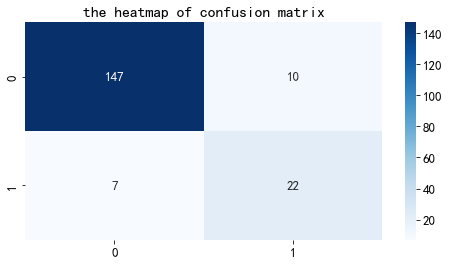

In [467]:
# confusion matrix(混淆矩阵)
cnf_matrix = confusion_matrix(Y_test,RF.predict(X_test))
print(f'confusion matrix：\n{cnf_matrix}\n')
plt.figure(figsize=(8,4))
sns.heatmap(cnf_matrix,annot=True,cmap=plt.cm.Blues,fmt='g')
plt.title('the heatmap of confusion matrix')
plt.show()

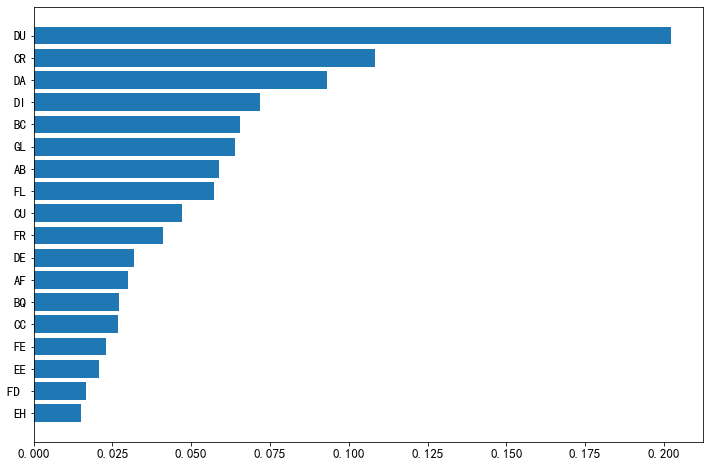

In [469]:
# Display feature importance(显示特征变量重要性)
df_ = pd.DataFrame({'features':RF.feature_names_in_,'importances_':RF.feature_importances_})
df_.sort_values(by='importances_',inplace=True)
plt.figure(figsize=(12,8))
plt.barh(width = df_.importances_,y = df_.features)
plt.show()

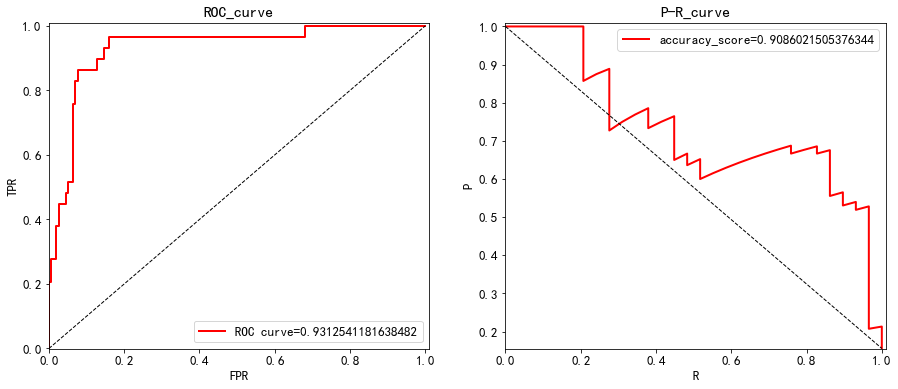

AUC： 0.9312541181638482
The total accuracy is： 0.9086021505376344


In [470]:
#ROC曲线和P-R曲线
#FTR:假阳性率，TPR：真阳性率
FPR,TPR,thresholds = roc_curve(Y_test,RF.predict_proba(X_test)[:,1],pos_label=1)
roc_auc = auc(FPR,TPR)  #auc值
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(FPR,TPR,color = 'r',linewidth=2,label=f'ROC curve={roc_auc}')
plt.plot([0,1],[0,1],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([-0.001,1.01])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')
plt.legend(loc = 'best')

plt.subplot(1,2,2)
PRE,REC,thresholds = precision_recall_curve(Y_test,RF.predict_proba(X_test)[:,1],pos_label=1)
plt.plot(REC,PRE,color = 'r',linewidth=2,label=f'accuracy_score={accuracy_score(Y_test,RF.predict(X_test))}')
plt.plot([0,1],[1,PRE.min()],color='k',linewidth=1,linestyle='--')
plt.xlim([-0.001,1.01])
plt.ylim([PRE.min()-0.001,1.01])
plt.xlabel('R')
plt.ylabel('P')
plt.title('P-R_curve')
plt.legend(loc = 'best')
plt.show()

print("AUC：",roc_auc)
print("The total accuracy is：",accuracy_score(Y_test,RF.predict(X_test)))

In [471]:
test_

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


#### model application(模型应用)

In [121]:
#test_X = test_.loc[:,Lasso_X]
#test_X = test_.loc[:,corr_lt]
# test_X = test_.loc[:,selector_X]

In [226]:
# 按照筛选的变量取出测试集数据
test_X = test_.loc[:,selector_X]
# 模型预测测试集
test_pred = XGBC_model.predict(test_X)
# 预测概率
test_pred_prob = XGBC_model.predict_proba(test_X)

In [227]:
# 构造预测概率dataframe
test_pred_prob_df = pd.DataFrame(test_pred_prob, columns=['class_0', 'class_1'])
test_pred_prob_df

,class_0,class_1
0,0.660142,0.339858
1,0.660142,0.339858
2,0.660142,0.339858
3,0.660142,0.339858
4,0.660142,0.339858


In [228]:
print('预测结果：',test_pred)

预测结果： [0 0 0 0 0]


### (submission)提交

In [229]:
submission = pd.DataFrame(columns=['Id','class_0','class_1'])
submission.Id = test_.Id
submission.class_0 = test_pred_prob_df.class_0
submission.class_1 = test_pred_prob_df.class_1
submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.660142,0.339858
1,010ebe33f668,0.660142,0.339858
2,02fa521e1838,0.660142,0.339858
3,040e15f562a2,0.660142,0.339858
4,046e85c7cc7f,0.660142,0.339858


In [86]:
submission.to_csv('/kaggle/working/submission.csv',index=False)

#submission.to_csv('submission.csv',index=False)